# EEG Quality Control

# Imports

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pyprep
import pyxdf
from utils import *
from scipy.signal import welch

## Get Data

In [2]:
xdf_filename = '/Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf'

df = get_event_data(event='RestingState', 
                    df=import_eeg_data(xdf_filename),
                    stim_df=get_stim(xdf_filename))

2025-03-10 17:42:02,013 - pyxdf.pyxdf - INFO - Importing XDF file /Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf...
2025-03-10 17:42:10,331 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2025-03-10 17:42:10,379 - pyxdf.pyxdf - INFO -   performing jitter removal...
2025-03-10 17:42:10,468 - pyxdf.pyxdf - INFO - Importing XDF file /Users/bryan.gonzalez/CUNY_subs/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf...
2025-03-10 17:42:11,602 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2025-03-10 17:42:11,635 - pyxdf.pyxdf - INFO -   performing jitter removal...


# Create MNE Raw Object

In [3]:
## Create MNE Raw object
ch_names = [f"E{i+1}" for i in range(df.shape[1] - 1)]
info = mne.create_info(ch_names, 
                       sfreq=1/df.lsl_time_stamp.diff().mean(), 
                       ch_types='eeg')
df.drop(columns=['lsl_time_stamp'], inplace=True)

raw = mne.io.RawArray(df.T * 1e-6, info=info) # multiplying by 1e-6 converts to volts

# Create a Cz reference
value = np.zeros((1, raw.n_times))
info = mne.create_info(["Cz"], raw.info['sfreq'], ch_types='eeg')
cz = mne.io.RawArray(value, info)
raw.add_channels([cz], force_update_info=True)

# Apply a montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
raw.set_montage(montage, on_missing='ignore')

Creating RawArray with float64 data, n_channels=128, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.


<RawArray | 129 x 299995 (300.0 s), ~295.4 MB, data loaded>

# Run Automated Processing Pipeline
(this will take some time)

In [4]:
prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(60, raw.info["sfreq"] / 2, 60),
    }
# these params set up the robust reference  - i.e. median of all channels and interpolate bad channels
prep = pyprep.PrepPipeline(raw, montage=montage, channel_wise=True, prep_params=prep_params)
prep_output = prep.fit()
raw_cleaned = prep_output.raw_eeg



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Removed notch frequencies (Hz):
     60.00 : 7482 windows
    120.00 : 7482 windows
    180.00 : 7482 windows
    239.00 : 7482 windows
    240.00 : 7482 windows
    241.00 : 7482 windows
    299.00 : 7482 windows
    300.00 : 7482 windows
    301.00 : 7482 windows
    359.00 : 7482 windows
    360.00 : 7482 windows
    361.00 : 7482 windows
    419.00 : 7482 windows
    420.00 : 7482 windows
    421.00 : 7482 windows
    479.00 : 7482 windows
    480.00 : 7482 windows
    481.00 : 7482 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 26
Total # of chunks: 5
Current chunk:
1
2
3
4
5

RANSAC done!


2025-03-10 17:45:48,777 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': [], 'bad_by_hf_noise': ['E74', 'E76', 'E77', 'E81', 'E82', 'E83', 'E84', 'E88', 'E89', 'E90', 'E94', 'E95'], 'bad_by_correlation': ['E128'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['E7', 'E106', 'E126'], 'bad_all': ['E84', 'E90', 'E76', 'E74', 'E81', 'Cz', 'E83', 'E95', 'E77', 'E94', 'E106', 'E7', 'E89', 'E128', 'E82', 'E126', 'E88']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 31
Total # of chunks: 4
Current chunk:
1
2
3
4

RANSAC done!


2025-03-10 17:47:29,660 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E25', 'E88', 'E128', 'E8'], 'bad_by_hf_noise': ['E84', 'E90', 'E95', 'E74', 'E81', 'E77', 'E94', 'E89', 'E88'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': ['E63', 'E126'], 'bad_all': ['E84', 'E90', 'E95', 'E74', 'E8', 'Cz', 'E81', 'E63', 'E77', 'E94', 'E89', 'E25', 'E128', 'E126', 'E88']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors


2025-03-10 17:47:30,192 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 42
Total # of chunks: 3
Current chunk:
1
2
3

RANSAC done!


2025-03-10 17:50:04,199 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E88', 'E8', 'E128', 'E25'], 'bad_by_hf_noise': ['E84', 'E95', 'E90', 'E74', 'E81', 'E77', 'E94', 'E89', 'E88'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': ['E63', 'E126'], 'bad_all': ['E84', 'E95', 'E90', 'E74', 'E8', 'Cz', 'E81', 'E63', 'E77', 'E94', 'E88', 'E89', 'E128', 'E126', 'E25']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors


2025-03-10 17:50:04,759 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 62
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!


2025-03-10 17:53:18,207 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E25', 'E128', 'E8', 'E88'], 'bad_by_hf_noise': ['E84', 'E95', 'E90', 'E74', 'E81', 'E77', 'E94', 'E89', 'E88'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': ['E63', 'E126', 'E1'], 'bad_all': ['E84', 'E95', 'E90', 'E74', 'E8', 'Cz', 'E81', 'E63', 'E1', 'E77', 'E94', 'E89', 'E25', 'E128', 'E126', 'E88']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 113 sensor positions
Interpolating 16 sensors


2025-03-10 17:53:19,196 - pyprep.reference - INFO - Iterations: 3


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 62
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!


2025-03-10 17:54:48,670 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E128', 'E8', 'E25', 'E88'], 'bad_by_hf_noise': ['E84', 'E95', 'E90', 'E74', 'E81', 'E77', 'E94', 'E89', 'E88'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': ['E63', 'E126', 'E1', 'E127'], 'bad_all': ['E84', 'E95', 'E90', 'E74', 'E8', 'Cz', 'E81', 'E63', 'E1', 'E77', 'E94', 'E88', 'E89', 'E127', 'E128', 'E126', 'E25']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 112 sensor positions
Interpolating 17 sensors


2025-03-10 17:54:49,202 - pyprep.reference - INFO - Iterations: 4


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 62
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!


2025-03-10 17:56:10,261 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': ['Cz'], 'bad_by_deviation': ['E25', 'E128', 'E8', 'E88'], 'bad_by_hf_noise': ['E84', 'E95', 'E90', 'E74', 'E81', 'E77', 'E94', 'E89', 'E88'], 'bad_by_correlation': ['E128', 'E88'], 'bad_by_SNR': ['E88'], 'bad_by_dropout': [], 'bad_by_ransac': ['E63', 'E126', 'E1', 'E127'], 'bad_all': ['E84', 'E95', 'E90', 'E74', 'E8', 'Cz', 'E81', 'E63', 'E1', 'E77', 'E94', 'E89', 'E127', 'E25', 'E128', 'E126', 'E88']}
2025-03-10 17:56:10,262 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 112 sensor positions
Interpolating 17 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 63
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!
Found 14 uniquely bad channels:

0 by NaN: []

0 by flat: []

4 by deviation: ['E8', 'E25', 'E88', 'E128']

9 by HF noise: ['E74', 'E77', 'E81', 'E84', 'E88', 'E89', 'E90', 'E94', 'E95']

2 by correlation: ['E88', 'E128']

1 by SNR: ['E88']

0 by dropout: []

2 by RANSAC: ['E119', 'E126']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 114 sensor positions
Interpolating 15 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lowe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 65
Total # of chunks: 2
Current chunk:
1
2

RANSAC done!


# Plot PSD

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


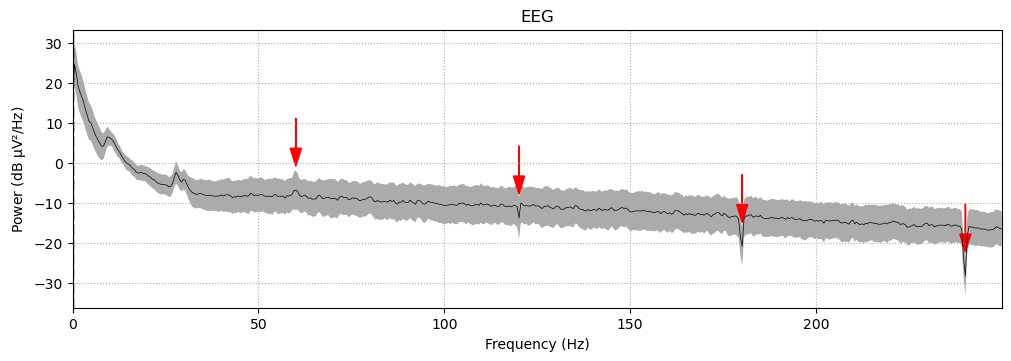

In [5]:
fig = raw_cleaned.plot_psd(tmax=np.inf, fmax=250, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

# Annotation Blinks and Muscle Artifacts

In [6]:
def annotate_blinks(
    raw: mne.io.Raw, ch_name: list[str] = ["E25", "E8"]
) -> mne.Annotations:
    """Annotate the blinks in the EEG signal.
 
    Args:
        raw (mne.io.Raw): The raw EEG data in mne format.
        ch_name (list[str]): The channels to use for the EOG. Default is
                             ["Fp1", "Fp2"]. I would suggest to use the
                             channels that are the most frontal (just above
                             the eyes). In the case of an EGI system the
                             channels would be "E25" and "E8".
 
    Returns:
        mne.Annotations: The annotations object containing the blink events.
    """
    eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=ch_name)
    blink_annotations = mne.annotations_from_events(
        eog_epochs.events,
        raw.info["sfreq"],
        event_desc={eog_epochs.events[0, 2]: "blink"},
    )
    return blink_annotations

def annotate_muscle(raw: mne.io.Raw) -> mne.Annotations:
    muscle_annotations, _ = mne.preprocessing.annotate_muscle_zscore(
        raw, 
        threshold=3, # this needs to be calibrated for the entire dataset
        ch_type='eeg', 
        min_length_good=0.1, 
        filter_freq=(95, 120), 
        )
 
    return muscle_annotations

In [7]:
# Applying a low pass filter to remove high frequency noise
raw_cleaned.filter(0.5, None)

blink_annotations = annotate_blinks(raw_cleaned, ch_name=["E25", "E8"])

muscle_annotations = annotate_muscle(raw_cleaned)

all_annotations = blink_annotations + muscle_annotations + raw.annotations
raw_cleaned.set_annotations(all_annotations)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Using EOG channels: E25, E8
EOG channel index for this subject is: [24  7]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Not setting metadata
106 matching events found
No baseline correction applied
Using data from preloaded Raw for 106 events and 1001 original time points ...
1 bad epochs dropped
Filtering raw data i

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



<RawArray | 129 x 299995 (300.0 s), ~295.4 MB, data loaded>

## Computing % Good Data

In [8]:
# Create a binary array
binary_mask = np.zeros(len(raw_cleaned.times), dtype=int)

# Iterate over annotations
for annot in raw_cleaned.annotations:
    onset_sample = int(annot['onset'] * raw_cleaned.info['sfreq'])
    duration_sample = int(annot['duration'] * raw_cleaned.info['sfreq'])
    binary_mask[onset_sample:onset_sample + duration_sample] = 1

percent_good = 1 - np.sum(binary_mask) / len(binary_mask)
print(f'Percent Good Data: {percent_good * 100:.2f}%')

Percent Good Data: 89.62%


## Quantifying Blinks and Muscle Artifacts through ICA

In [9]:

ica = mne.preprocessing.ICA(n_components=None, method='picard')
ica.fit(raw_cleaned)
ica.plot_sources(raw_cleaned)
comp_idx, scores = ica.find_bads_muscle(raw_cleaned)

# Remove the muscle artifacts
raw_cleaned_ica = ica.apply(raw_cleaned, exclude=comp_idx)


Fitting ICA to data using 125 channels (please be patient, this may take a while)
Omitting 31217 of 299995 (10.41%) samples, retaining 268778 (89.59%) samples.
Selecting by non-zero PCA components: 113 components
Fitting ICA took 317.4s.
Creating RawArray with float64 data, n_channels=113, n_times=299995
    Range : 0 ... 299994 =      0.000 ...   300.004 secs
Ready.


2025-03-10 18:06:40,611 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.
Using pyopengl with version 3.1.6
Setting 31217 of 299995 (10.41%) samples to NaN, retaining 268778 (89.59%) samples.
Effective window size : 2.048 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1149, using nperseg = 1149
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 249, using nperseg = 249
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1291, using nperseg = 1291
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 683, using nperseg = 683
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Ap

Applying ICA to Raw instance


/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1076, using nperseg = 1076
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 760, using nperseg = 760
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 998, using nperseg = 998
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Applications/MNE-Python/1.8.0_0/.mne-python/lib/python3.12/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 476, using nperseg = 476
  return _func(*args, **kwargs)
/Users/bryan.gonzalez/Appl

    Transforming to ICA space (113 components)
    Zeroing out 1 ICA component
    Projecting back using 125 PCA components


# Ocular Artifacts

Using EOG channels: E8, E25
EOG channel index for this subject is: [ 7 24]
Omitting 31217 of 299995 (10.41%) samples, retaining 268778 (89.59%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel E8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events a

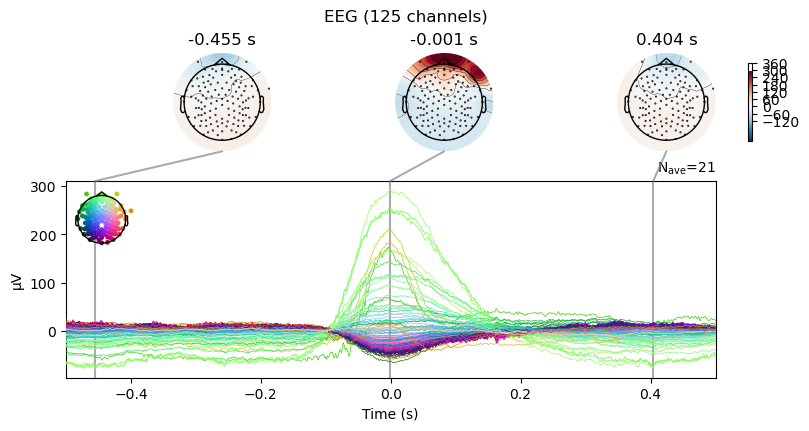

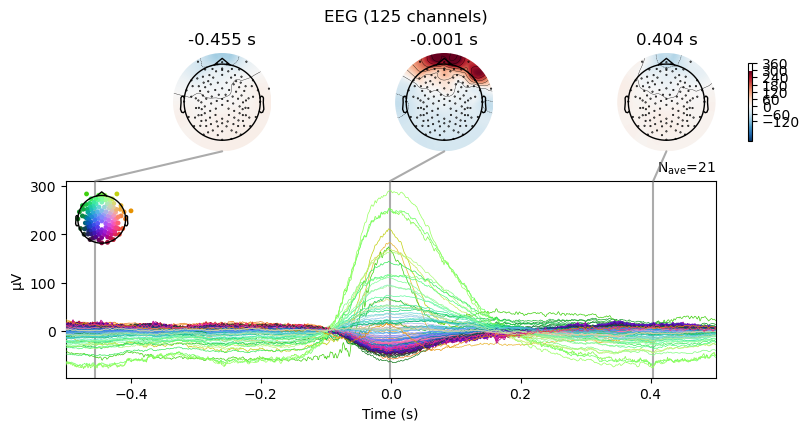

In [10]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw_cleaned, ch_name=['E8', 'E25']).average(picks="all")
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint()